In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [2]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = [dict(), dict(), dict()]
    att = dict()
    radar_idx = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        file = glob.glob(model_dir + "/**/radar_index.pickle", recursive = True)[0]
        with open(file, 'rb') as f:
            radar_idx[m] = pickle.load(f)
        
        if 'BirdFluxGraphLSTM' in m or m == 'testFluxMLP':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_fluxes_*.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_mtr_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att, radar_idx

In [30]:
def compare_fluxes(radar_index, fluxes_model, fluxes_radar, trial=0, context=0, src=5, dst=6):

    f_model = torch.cat([f for f in fluxes_model[trial].values()], dim=-1)
    f_model = (f_model - f_model.permute(1, 0, 2))
    f_radar = torch.cat([f[..., context:] for f in fluxes_radar[trial].values()], dim=-1)

    
    f_model = f_model[..., 1:]
    f_radar = f_radar[..., :-1]
    
    idx = np.where(f_model.detach().numpy()!=0)
    diff = (f_model - f_radar).detach().numpy()
    print((diff[idx]**2).mean())
    
    fig, ax = plt.subplots(figsize=(18,5))
    ax.plot(f_radar[src,dst,:].detach().numpy(), label='radar', alpha=0.5)
    ax.plot(f_model[src,dst,:].detach().numpy(), label='model', alpha=0.5)
    ax.legend()

    fig, ax = plt.subplots(figsize=(8,8))
    fr = f_radar.detach().numpy()
    fm = f_model.detach().numpy()
    ax.scatter(fr.flatten(), fm.flatten(), alpha=0.2)
    ax.set(xlabel='radar fluxes', ylabel='model fluxes');

In [4]:
def plot_fluxes(voronoi, G, all_fluxes, results, trial=0, encoder=0, context=0, bird_scales={}, m='BirdFluxGraphLSTM'):

    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in all_fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results[m].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[trial]))])


    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new

In [11]:
def plot_net_fluxes(voronoi, G, fluxes, results, trial=0, encoder=0, context=0, bird_scales={}, m='BirdFluxGraphLSTM', compute_net=True):
    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results[m].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val1 = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            if compute_net:
                val = val1 - val2
            else:
                val = val1
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                if val > 0 and not boundary1 and not boundary2:
                #if not boundary1 and not boundary2:
#                     print(val, val2)
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred net fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new

In [5]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

In [6]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_lstm_without_dummy_radars_encoder_batch4_n_hidden64']
results0, bird_scales0, fluxes0, _, _ = load_results(models, experiments, base_dir)

1


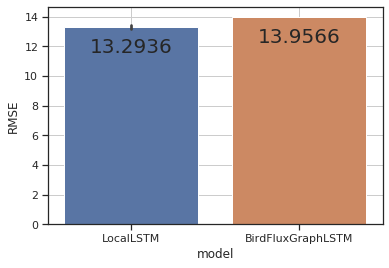

In [7]:
fig = utils.plot_average_errors(results0, boundary=boundary, night_only=True)

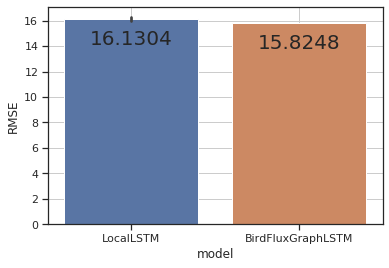

In [8]:
fig = utils.plot_average_errors(results0, boundary=[], night_only=True)

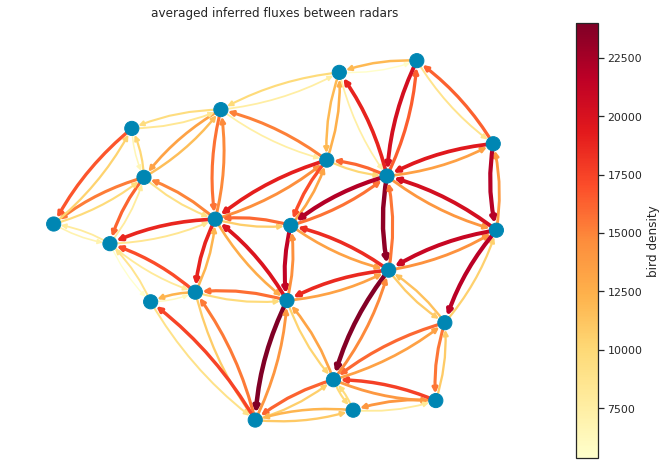

In [9]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes0[0], results0, trial=0, encoder=1, bird_scales=bird_scales0)

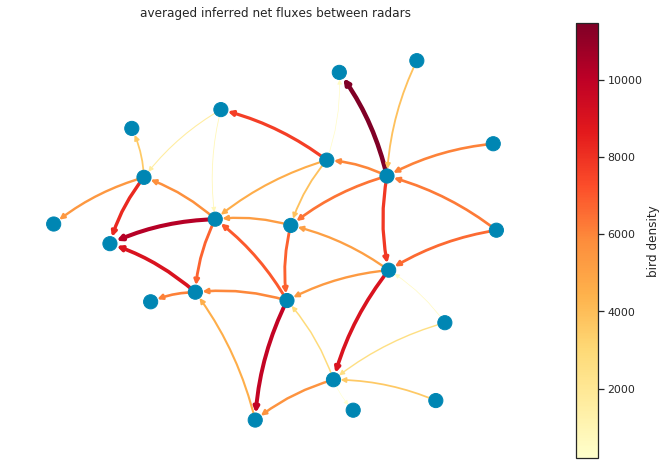

In [12]:
G_new = plot_net_fluxes(voronoi, G, fluxes0[0], results0, trial=0, encoder=1, bird_scales=bird_scales0)

4.138854213735218e-05


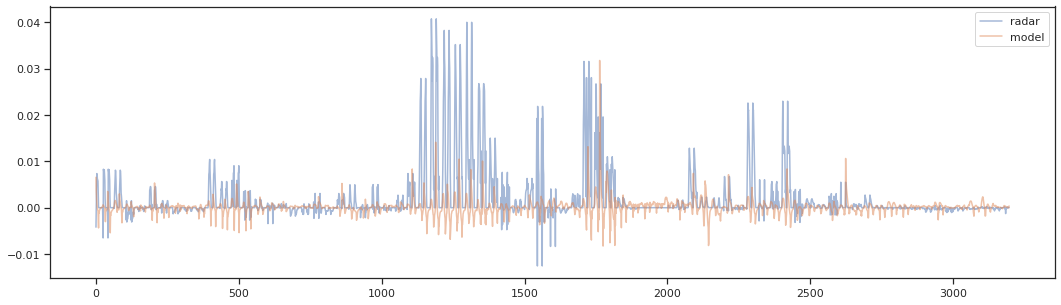

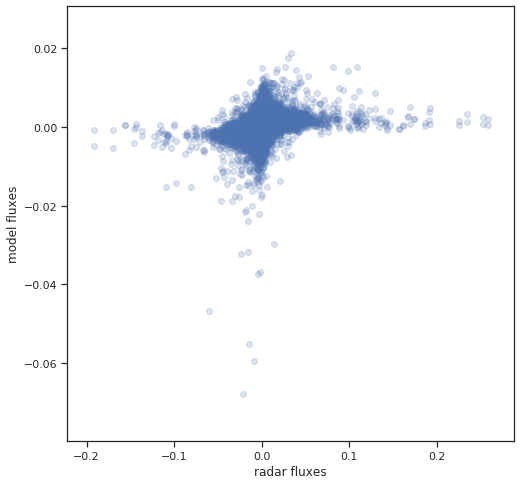

In [29]:
compare_fluxes(inner_radars, fluxes0[0], fluxes0[1], trial=0, context=24, src=11, dst=2)

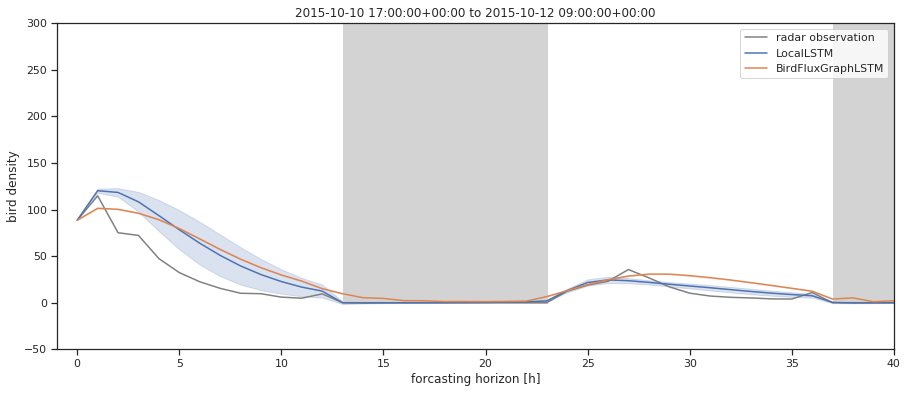

In [28]:
fig = utils.plot_example_prediction(results0, 'dehnr', 44, max=300, min=-50)